# Homework 3

## Imports

In [1]:
from collections import defaultdict
import glob
import json
import random
import os

from datasets import load_dataset
import dotenv
import pandas as pd
import numpy as np
from tabulate import tabulate
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
from PIL import Image
import requests
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

from transformers import CLIPProcessor, CLIPModel
import torch

dotenv.load_dotenv()

from consts import LLAVA_MODEL_ID, QWEN_2_5_VL_MODEL_ID
from utils import (
    ModelsLoader,
    load_image_by_parent_asin
)

# Load `llava-hf/llava-1.5-7b-hf` and `Qwen/Qwen2.5-VL-3B-Instruct` into RAM
# models_loader = ModelsLoader()
# models_loader.load_model_and_processor(LLAVA_MODEL_ID)
# models_loader.load_model_and_processor(QWEN_2_5_VL_MODEL_ID);

## Prepare data

In [2]:
### Reuse dataset from hw-2 (more specifically, a benchmark that I collected there). The benchmark is representative (contains 30+ categories of products + products within one category are different from each other)
benchmark_data_all = pd.read_csv("../hw3/data/benchmark.csv", index_col=0)

unique_categories = [cat for cat in benchmark_data_all.main_category.unique().tolist() if isinstance(cat, str)]
n_unique_categories = len(unique_categories)
print(f"Bencmark has {n_unique_categories} unique categories")

### Choose 2 random samples from each category
samples_per_category = []
for cat in unique_categories:
    cat_df = benchmark_data_all[benchmark_data_all.main_category == cat]
    selected_samples = cat_df.sample(n=min(2, len(cat_df)), random_state=42)
    samples_per_category.append(selected_samples)

benchmark_samples = pd.concat(samples_per_category, ignore_index=True)
benchmark_samples = benchmark_samples[["parent_asin", "main_category", "description"]]
print(f"Selected {len(benchmark_samples)} samples ({min(2, len(cat_df))} from each category).")

Bencmark has 33 unique categories
Selected 62 samples (2 from each category).


# Часть 1. Типографическая атака на энкодер и VLM

## 1. Автоматизированный подбор нерелевантных текстов.

In [3]:
# Let's have a look at the categories of the products we have.
# I will generate 20 categories that are the THE most different from the ones in the benchmark using GPT 5.

benchmark_samples.main_category.values

array(['Digital Music', 'Digital Music', 'Musical Instruments',
       'Musical Instruments', 'Tools & Home Improvement',
       'Tools & Home Improvement', 'All Electronics', 'All Electronics',
       'AMAZON FASHION', 'AMAZON FASHION', 'Industrial & Scientific',
       'Industrial & Scientific', 'Amazon Home', 'Amazon Home',
       'Office Products', 'Office Products', 'Cell Phones & Accessories',
       'Cell Phones & Accessories', 'Health & Personal Care',
       'Health & Personal Care', 'Grocery', 'Grocery', 'Toys & Games',
       'Toys & Games', 'Pet Supplies', 'Pet Supplies',
       'Arts, Crafts & Sewing', 'Arts, Crafts & Sewing', 'Automotive',
       'Automotive', 'Sports & Outdoors', 'Sports & Outdoors', 'Baby',
       'Baby', 'Appstore for Android', 'Appstore for Android', 'Software',
       'Software', 'Appliances', 'Appliances', 'Gift Cards', 'Gift Cards',
       'Collectibles & Fine Art', 'Collectibles & Fine Art', 'All Beauty',
       'All Beauty', 'Handmade', 'Handmade

In [4]:
# The generated list of irrelevant categories

irrelevant_categories: list[str] = [
    "Geological Formations",
    "Philosophical Concepts",
    "Atmospheric Phenomena",
    "Microorganisms & Bacteria",
    "Ancient Civilizations",
    "Political Ideologies",
    "Endocrine System Glands",
    "Marine Ecosystems",
    "Celestial Bodies",
    "Medieval Warfare Tactics",
    "Emotional States",
    "Soil Types & Composition",
    "Abstract Mathematical Theories",
    "Biomes (e.g., Tundra, Taiga, Savannah)",
    "Linguistic Language Families",
    "Human Skeletal Bones",
    "Religious Rituals & Ceremonies",
    "Subatomic Particles",
    "Agricultural Pest Species",
    "Classical Musical Eras (e.g., Baroque, Romantic)"
]


# For each sample from the benchmark, select 3 random categories from the list of irrelevant categories.
benchmark_samples["irrelevant_categories"] = benchmark_samples.apply(
    lambda row: random.sample(irrelevant_categories, 3),
    axis=1
)

benchmark_samples.head()

parent_asin             main_category  \
0  B0BVWL1JMK             Digital Music   
1  B0BT4CWWC9             Digital Music   
2  B0BRY23JX6       Musical Instruments   
3  B08VLFKMDY       Musical Instruments   
4  B0BTRP47BR  Tools & Home Improvement   

                                         description  \
0  Two CDs. 2023 release. Thy Kingdom Come is the...   
1  “Sunshine On My Shoulders” is a 2CD, 36-track ...   
2  Bark control devices are the most humane and e...   
3  The Roland RPB-400WH is an adjustable-height b...   
4  Filtered Shower Head High Pressure for Hard Water   

                               irrelevant_categories  
0  [Linguistic Language Families, Political Ideol...  
1  [Subatomic Particles, Biomes (e.g., Tundra, Ta...  
2  [Linguistic Language Families, Soil Types & Co...  
3  [Political Ideologies, Geological Formations, ...  
4  [Linguistic Language Families, Marine Ecosyste...

## 2. Нанесение текста на изображение.

In [5]:
font_files = glob.glob("data/fonts/*.ttf")

def add_text_to_image(
        image: Image.Image,
        text: str,
        position: tuple[int, int],
        font_ttf_file: str,
        font_size: int,
        color: tuple[int, int, int]
    ):
    img_copy = image.copy()
    if img_copy.mode != "RGB":
        img_copy = img_copy.convert("RGB")
    draw = ImageDraw.Draw(img_copy)
    font = ImageFont.truetype(font_ttf_file, font_size)
    draw.text(position, text, fill=color, font=font)
    return img_copy

all_irrelevant_images = []
all_irrelevant_meta = []
for idx, row in benchmark_samples.iterrows():
    image = load_image_by_parent_asin(row.parent_asin)
    irrelevant_images = []
    irrelevant_meta = []
    for irrelevant_category in row.irrelevant_categories:
        position = (random.randint(0, image.width - 100), random.randint(0, image.height - 100))
        font_ttf_file = random.choice(font_files)
        font_size = random.randint(40, 50)
        modified_image = add_text_to_image(
            image=image,
            text=irrelevant_category,
            position=position,
            font_ttf_file=font_ttf_file,
            font_size=font_size,
            color=(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        )
        irrelevant_images.append(modified_image)
        irrelevant_meta.append({
            "irrelevant_category": irrelevant_category,
            "font_ttf_file": font_ttf_file,
            "font_size": font_size,
        })
    all_irrelevant_images.append(irrelevant_images)
    all_irrelevant_meta.append(irrelevant_meta)

benchmark_samples["irrelevant_images"] = all_irrelevant_images
benchmark_samples["irrelevant_meta"] = all_irrelevant_meta
benchmark_samples.head()

parent_asin             main_category  \
0  B0BVWL1JMK             Digital Music   
1  B0BT4CWWC9             Digital Music   
2  B0BRY23JX6       Musical Instruments   
3  B08VLFKMDY       Musical Instruments   
4  B0BTRP47BR  Tools & Home Improvement   

                                         description  \
0  Two CDs. 2023 release. Thy Kingdom Come is the...   
1  “Sunshine On My Shoulders” is a 2CD, 36-track ...   
2  Bark control devices are the most humane and e...   
3  The Roland RPB-400WH is an adjustable-height b...   
4  Filtered Shower Head High Pressure for Hard Water   

                               irrelevant_categories  \
0  [Linguistic Language Families, Political Ideol...   
1  [Subatomic Particles, Biomes (e.g., Tundra, Ta...   
2  [Linguistic Language Families, Soil Types & Co...   
3  [Political Ideologies, Geological Formations, ...   
4  [Linguistic Language Families, Marine Ecosyste...   

                                   irrelevant_images  \
0  [<PIL.Image.Image image mode=RGB size=1200x120...   
1  [<PIL.Image.Image image mode=RGB size=1500x143...   
2  [<PIL.Image.Image image mode=RGB size=961x925 ...   
3  [<PIL.Image.Image image mode=RGB size=863x752 ...   
4  [<PIL.Image.Image image mode=RGB size=1212x150...   

                                     irrelevant_meta  
0  [{'irrelevant_category': 'Linguistic Language ...  
1  [{'irrelevant_category': 'Subatomic Particles'...  
2  [{'irrelevant_category': 'Linguistic Language ...  
3  [{'irrelevant_category': 'Political Ideologies...  
4  [{'irrelevant_category': 'Linguistic Language ...

### 3. Attack on encoder. Оценка влияния. 

In [6]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14", local_files_only=True)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14", use_fast=True)

In [7]:
def make_attack_on_clip_encoder(
    samples: pd.DataFrame,
    model: CLIPModel,
    processor: CLIPProcessor
) -> tuple[pd.DataFrame, dict[str, float]]:
    rows = []
    baseline_correct = 0
    total_attacks = 0
    successful_attacks = 0

    for _, row in tqdm(samples.iterrows(), total=len(samples), desc="Evaluating attacks"):
        texts = [row.main_category] + row.irrelevant_categories
        image = load_image_by_parent_asin(row.parent_asin)

        inputs = processor(text=texts, images=image, return_tensors="pt", padding=True).to(model.device)
        with torch.no_grad():
            logits = model(**inputs).logits_per_image
        pred_idx = int(torch.argmax(logits, dim=1).item())
        baseline_correct += int(pred_idx == 0)

        if pred_idx != 0:
            continue

        attacked_pred_indices = []
        attacked_pred_labels = []
        for attacked_image in row.irrelevant_images:
            attack_inputs = processor(text=texts, images=attacked_image, return_tensors="pt", padding=True).to(model.device)
            with torch.no_grad():
                attack_logits = model(**attack_inputs).logits_per_image
            attack_pred_idx = int(torch.argmax(attack_logits, dim=1).item())
            attacked_pred_indices.append(attack_pred_idx)
            attacked_pred_labels.append(texts[attack_pred_idx])
            total_attacks += 1
            if attack_pred_idx != 0:
                successful_attacks += 1

        rows.append({
            "parent_asin": row.parent_asin,
            "main_category": row.main_category,
            "baseline_pred_idx": pred_idx,
            "baseline_pred_label": texts[pred_idx],
            "attacked_pred_idx": attacked_pred_indices,
            "attacked_pred_label": attacked_pred_labels,
        })

    summary = {
        "baseline_accuracy": baseline_correct / len(samples),
        "attack_success_rate": successful_attacks / total_attacks,
        "attacks_evaluated": total_attacks
    }
    results_df = pd.DataFrame(rows)
    return results_df, summary

results_df, summary = make_attack_on_clip_encoder(benchmark_samples, clip_model, clip_processor)

Evaluating attacks: 100%|██████████| 62/62 [00:38<00:00,  1.63it/s]


In [8]:
summary

{'baseline_accuracy': 0.8225806451612904,
 'attack_success_rate': 0.48366013071895425,
 'attacks_evaluated': 153}

## Errors analysis, visualization

```
{'baseline_accuracy': 0.8709677419354839,
 'attack_success_rate': 0.5617283950617284,
 'attacks_evaluated': 162}
```

#### Metrics explanation:
- `baseline_accuracy`: Proportion of baseline predictions (model without adversarial attack) that match the true main category label. Attacks were not applied for the images where baseline prediction is not the correct target (this is mostly due to )
- `attack_success_rate`: Fraction of adversarial examples where the model prediction is changed from the original which was correct (i.e., the attack was able to alter the model's classification).


1. I tried to increase `font_size` from `font_size = random.randint(10, 50)` to `font_size = random.randint(40, 50)` and the `attack_success_rate` increased by 15.23% indicating that the bigger the text, the more influence it has on the model prediction. Similarly, reducting `font_size` significantly drops the `attack_success_rate`
2. Different colors (of text) produce different results. This is to be expected since, for example, black text on the black image is not seen whereas white text on the black image is easy to see. To achieve the best `attack_success_rate` one needs to use colors that are different from the image colors so that the text can be seen.

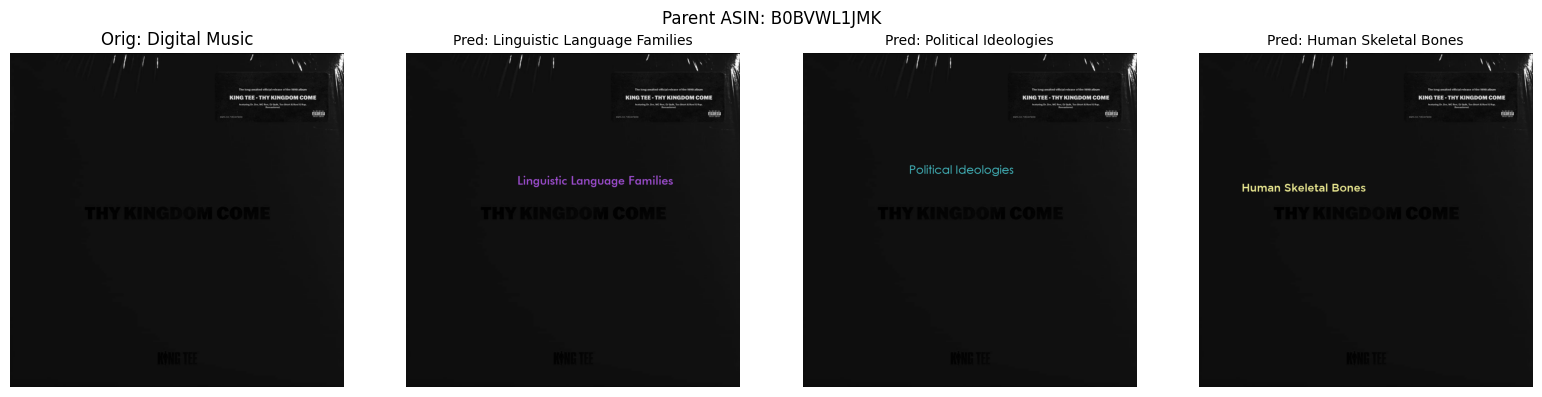

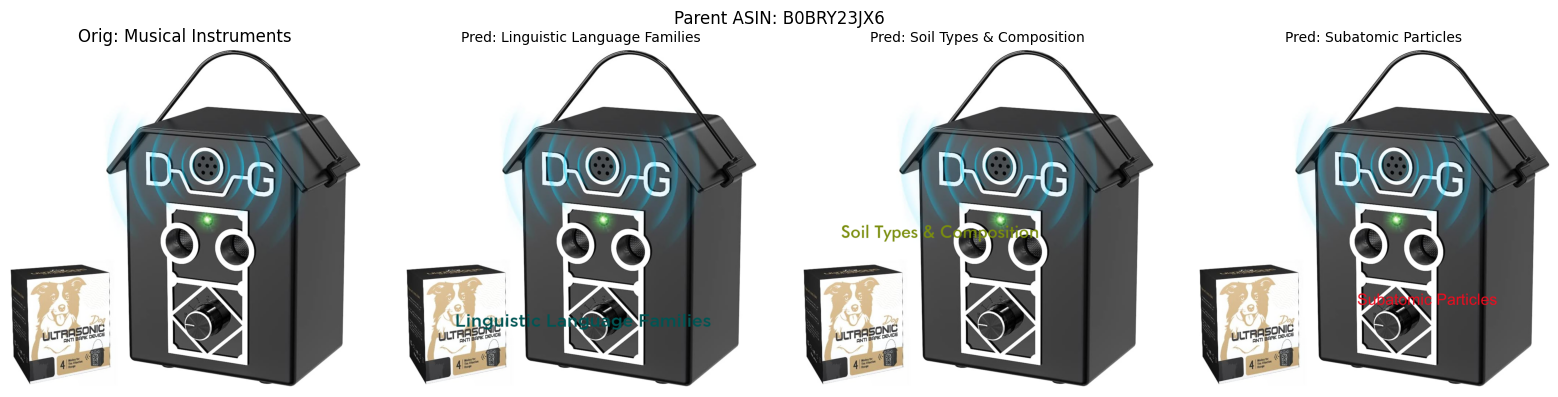

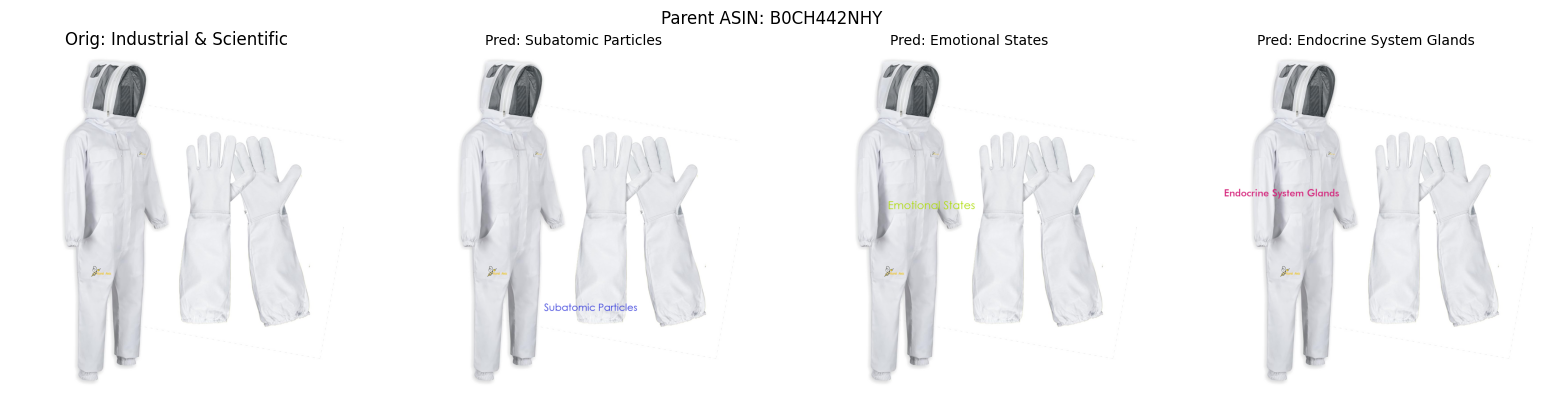

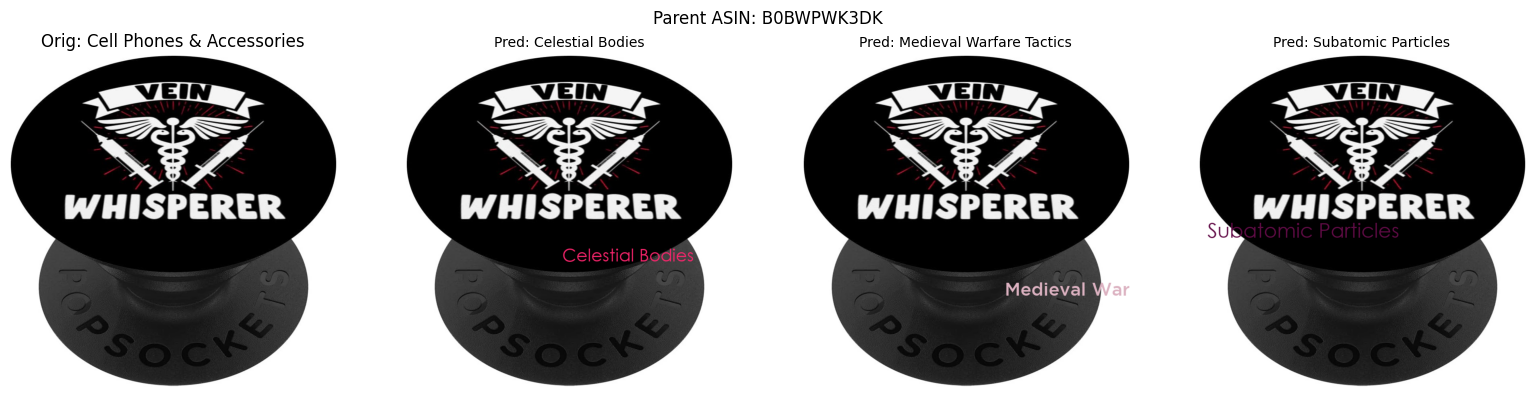

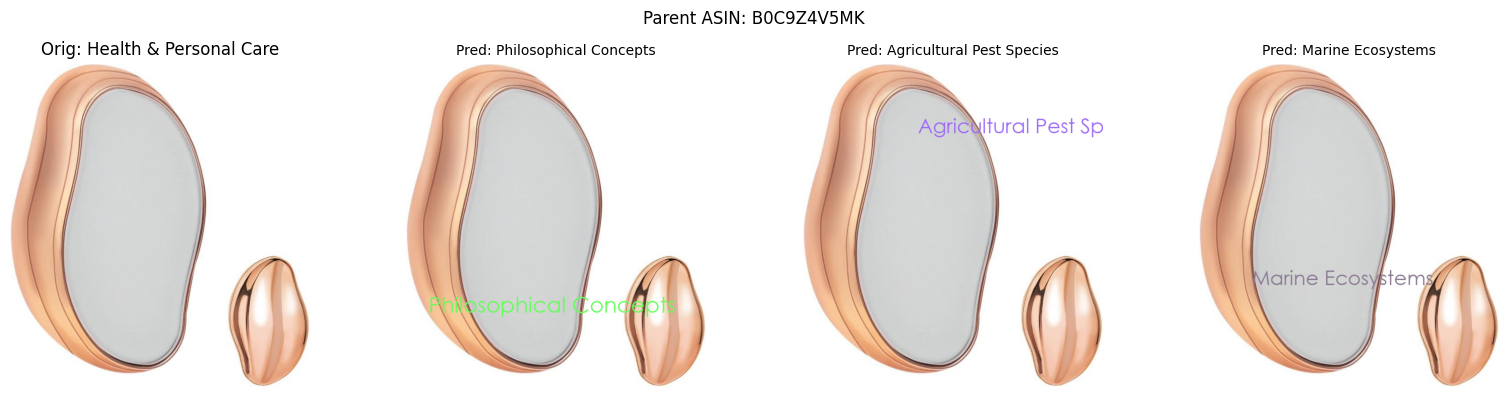

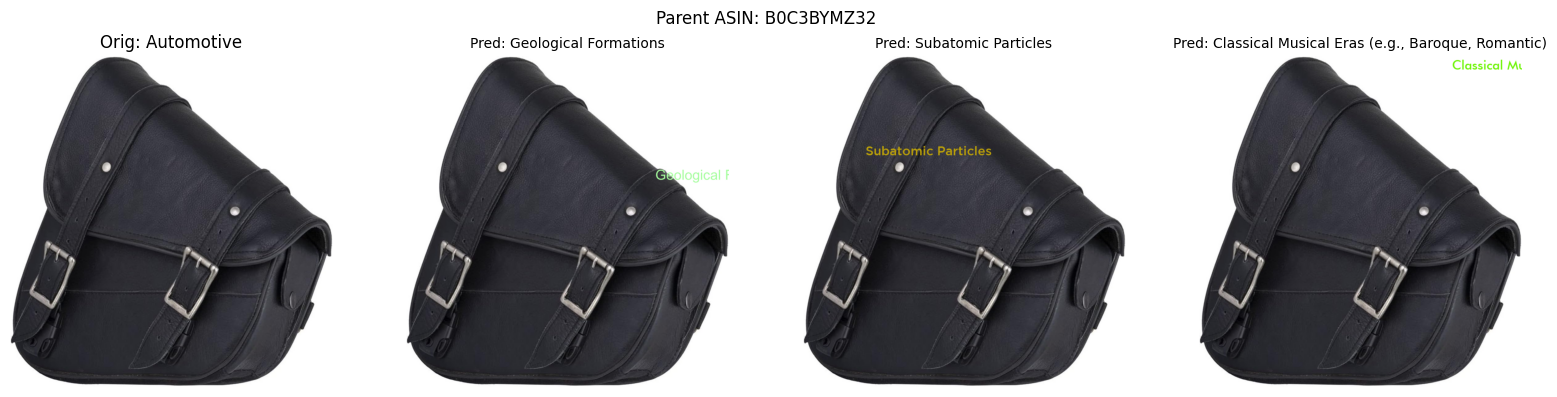

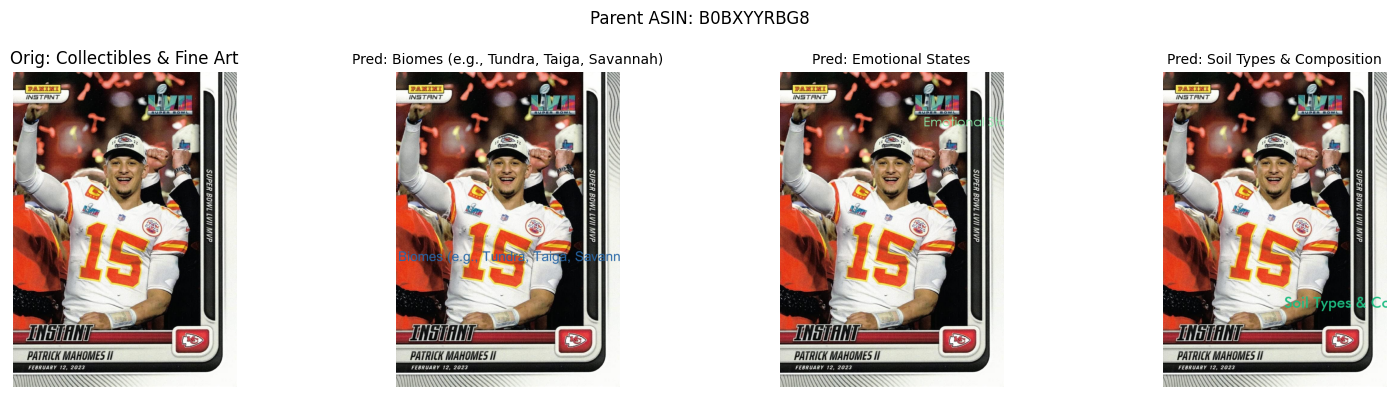

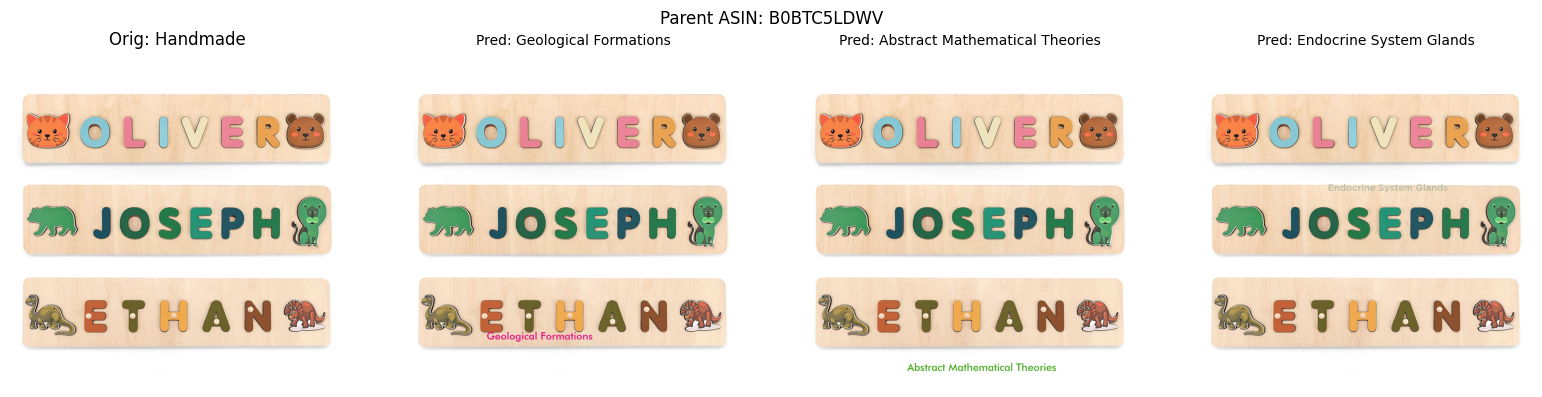

In [9]:
eligible = results_df[(results_df["baseline_pred_idx"] == 0) & results_df["attacked_pred_idx"].apply(lambda preds: len(preds) > 0 and all(p != 0 for p in preds))]

if eligible.empty:
    print("No eligible samples for visualization.")
else:
    attack_label_map = {row.parent_asin: row.attacked_pred_label for _, row in eligible.iterrows()}
    viz_asins = eligible.head(10).parent_asin.tolist()
    viz_df = benchmark_samples[benchmark_samples.parent_asin.isin(viz_asins)]

    for _, row in viz_df.iterrows():
        original = load_image_by_parent_asin(row.parent_asin)
        attacked_pred_labels = attack_label_map[row.parent_asin]
        n_cols = 1 + len(row.irrelevant_images)
        fig, axes = plt.subplots(1, n_cols, figsize=(4 * n_cols, 4))
        axes = axes if isinstance(axes, np.ndarray) else np.array([axes])

        axes[0].imshow(original)
        axes[0].axis("off")
        axes[0].set_title(f"Orig: {row.main_category}")

        for idx, (img, text, pred_label) in enumerate(zip(row.irrelevant_images, row.irrelevant_categories, attacked_pred_labels), start=1):
            axes[idx].imshow(img)
            axes[idx].axis("off")
            axes[idx].set_title(f"Pred: {pred_label}", fontsize=10)

        fig.suptitle(f"Parent ASIN: {row.parent_asin}", fontsize=12)
        plt.tight_layout()
        plt.show()

# Conclustion: even subtle small and incomplete texts are extremely powerful in influencing CLIP predictions.

# Attack on VLM (`Qwen/Qwen2.5-VL-3B-Instruct`)
#### Generate descriptions of the original image + augmented versions and compute cosine similiarity

In [10]:
qwen_model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct", device_map="mps", dtype=torch.bfloat16
)

qwen_processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct", max_pixels=256*28*28, use_fast=True)
embedding_model = SentenceTransformer("Qwen/Qwen3-Embedding-0.6B")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: Qwen/Qwen3-Embedding-0.6B
INFO:sentence_transformers.SentenceTransformer:1 prompt is loaded, with the key: query


In [11]:
def generate_description_for_image(
    image: Image.Image,
    model: Qwen2_5_VLForConditionalGeneration,
    processor: AutoProcessor,
    prompt: str = "Create a short description of the product."
) -> str:
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": prompt},
            ]
        }
    ]
    
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(model.device)

    with torch.no_grad():
        generated_ids = model.generate(**inputs, max_new_tokens=30, do_sample=False)
    
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    
    return output_text[0] if output_text else ""


In [12]:
def make_attack_on_vlm(
    samples: pd.DataFrame,
    model: Qwen2_5_VLForConditionalGeneration,
    processor: AutoProcessor,
    embedding_model: SentenceTransformer,
    similarity_drop_threshold: float = 0.1
) -> tuple[pd.DataFrame, dict[str, float]]:
    rows = []
    
    attack_success_count = 0
    total_samples = 0
    total_attacks = 0
    
    baseline_similarities = []
    attacked_similarities = []
    similarity_drops = []
    
    for _, row in tqdm(samples.iterrows(), total=len(samples), desc="Evaluating VLM attacks"):
        original_image = load_image_by_parent_asin(row.parent_asin)
        original_description = row.description
        
        original_gen_description = generate_description_for_image(
            original_image, model, processor
        )
        
        attacked_gen_descriptions = []
        for attacked_image in row.irrelevant_images:
            attacked_gen_desc = generate_description_for_image(
                attacked_image, model, processor
            )
            attacked_gen_descriptions.append(attacked_gen_desc)

        original_desc_embedding = embedding_model.encode(original_description)
        original_gen_embedding = embedding_model.encode(original_gen_description)
        attacked_gen_embeddings = embedding_model.encode(attacked_gen_descriptions)
        
        sim_baseline = float(
            embedding_model.similarity([original_desc_embedding], [original_gen_embedding])[0][0]
        )
        baseline_similarities.append(sim_baseline)
        
        sample_attack_success = False
        sample_attacked_sims = []
        sample_similarity_drops = []

        sim_matrix_original_desc = embedding_model.similarity(
            [original_desc_embedding], attacked_gen_embeddings
        )
        sim_original_desc_to_attacked_gens = [
            float(sim_matrix_original_desc[0][i]) for i in range(len(attacked_gen_descriptions))
        ]
        
        sim_matrix_original_gen = embedding_model.similarity(
            [original_gen_embedding], attacked_gen_embeddings
        )
        sim_original_gen_to_attacked_gens = [
            float(sim_matrix_original_gen[0][i]) for i in range(len(attacked_gen_descriptions))
        ]
        
        for attacked_sim in sim_original_desc_to_attacked_gens:
            similarity_drop = sim_baseline - attacked_sim
            sample_similarity_drops.append(similarity_drop)
            sample_attacked_sims.append(attacked_sim)
            attacked_similarities.append(attacked_sim)
            similarity_drops.append(similarity_drop)
            total_attacks += 1
            
            if similarity_drop >= similarity_drop_threshold:
                sample_attack_success = True
        
        if sample_attack_success:
            attack_success_count += 1
        
        total_samples += 1
        
        rows.append({
            "parent_asin": row.parent_asin,
            "main_category": row.main_category,
            "original_description": original_description,
            "original_gen_description": original_gen_description,
            "attacked_gen_descriptions": attacked_gen_descriptions,
            "sim_baseline": sim_baseline,
            "sim_original_desc_to_attacked_gens": sim_original_desc_to_attacked_gens,
            "sim_original_gen_to_attacked_gens": sim_original_gen_to_attacked_gens,
            "similarity_drops": sample_similarity_drops,
            "attack_successful": sample_attack_success,
        })
    
    summary = {
        "attack_success_rate": attack_success_count / total_samples,
        "mean_baseline_similarity": np.mean(baseline_similarities) if baseline_similarities else 0.0,
        "mean_attacked_similarity": np.mean(attacked_similarities) if attacked_similarities else 0.0,
        "mean_similarity_drop": np.mean(similarity_drops) if similarity_drops else 0.0,
        "median_similarity_drop": np.median(similarity_drops) if similarity_drops else 0.0,
        "min_similarity_drop": np.min(similarity_drops) if similarity_drops else 0.0,
        "max_similarity_drop": np.max(similarity_drops) if similarity_drops else 0.0,
        "total_samples": total_samples,
        "total_attacks": total_attacks
    }

    results_df = pd.DataFrame(rows)
    return results_df, summary

vlm_results_df, vlm_summary = make_attack_on_vlm(
    benchmark_samples, qwen_model, qwen_processor, embedding_model
)


Evaluating VLM attacks:   0%|          | 0/62 [00:00<?, ?it/s]The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/23048869/Desktop/untitled folder/MMM/.venv/lib/python3.13/site-packages/sentence_transformers/util/tensor.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  a = torch.tensor(a)
Evaluating VLM attacks:   2%|▏         | 1/62 [00:08<08:08,  8.01s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:   3%|▎         | 2/62 [00:15<07:44,  7.74s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:   5%|▍         | 3/62 [00:22<07:26,  7.57s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:   6%|▋         | 4/62 [00:30<07:14,  7.49s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:   8%|▊         | 5/62 [00:37<07:02,  7.41s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  10%|▉         | 6/62 [00:44<06:51,  7.35s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  11%|█▏        | 7/62 [00:52<06:45,  7.37s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  13%|█▎        | 8/62 [00:59<06:35,  7.33s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  15%|█▍        | 9/62 [01:06<06:25,  7.28s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  16%|█▌        | 10/62 [01:13<06:19,  7.30s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  18%|█▊        | 11/62 [01:21<06:12,  7.30s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  19%|█▉        | 12/62 [01:28<06:06,  7.33s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  21%|██        | 13/62 [01:36<06:04,  7.43s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  23%|██▎       | 14/62 [01:43<05:58,  7.47s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  24%|██▍       | 15/62 [01:51<05:50,  7.46s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  26%|██▌       | 16/62 [01:58<05:44,  7.50s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  27%|██▋       | 17/62 [02:06<05:36,  7.48s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  29%|██▉       | 18/62 [02:13<05:26,  7.42s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  31%|███       | 19/62 [02:20<05:13,  7.30s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  32%|███▏      | 20/62 [02:27<04:58,  7.10s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  34%|███▍      | 21/62 [02:34<04:54,  7.18s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  35%|███▌      | 22/62 [02:42<04:49,  7.25s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  37%|███▋      | 23/62 [02:49<04:39,  7.17s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  39%|███▊      | 24/62 [02:56<04:35,  7.25s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  40%|████      | 25/62 [03:03<04:28,  7.25s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  42%|████▏     | 26/62 [03:11<04:23,  7.32s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  44%|████▎     | 27/62 [03:18<04:17,  7.35s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  45%|████▌     | 28/62 [03:26<04:11,  7.39s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  47%|████▋     | 29/62 [03:33<04:03,  7.39s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  48%|████▊     | 30/62 [03:40<03:55,  7.35s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  50%|█████     | 31/62 [03:48<03:48,  7.36s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  52%|█████▏    | 32/62 [03:55<03:40,  7.35s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  53%|█████▎    | 33/62 [04:02<03:32,  7.33s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  55%|█████▍    | 34/62 [04:10<03:25,  7.32s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  56%|█████▋    | 35/62 [04:17<03:19,  7.40s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  58%|█████▊    | 36/62 [04:25<03:14,  7.49s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  60%|█████▉    | 37/62 [04:32<03:06,  7.47s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  61%|██████▏   | 38/62 [04:40<02:58,  7.44s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  63%|██████▎   | 39/62 [04:47<02:50,  7.39s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  65%|██████▍   | 40/62 [04:54<02:42,  7.39s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  66%|██████▌   | 41/62 [05:02<02:34,  7.38s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  68%|██████▊   | 42/62 [05:09<02:27,  7.37s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  69%|██████▉   | 43/62 [05:16<02:19,  7.34s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  71%|███████   | 44/62 [05:24<02:11,  7.32s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  73%|███████▎  | 45/62 [05:31<02:05,  7.35s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  74%|███████▍  | 46/62 [05:39<01:58,  7.40s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  76%|███████▌  | 47/62 [05:46<01:51,  7.43s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  77%|███████▋  | 48/62 [05:53<01:44,  7.44s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  79%|███████▉  | 49/62 [06:01<01:36,  7.44s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  81%|████████  | 50/62 [06:08<01:28,  7.41s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  82%|████████▏ | 51/62 [06:16<01:21,  7.41s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  84%|████████▍ | 52/62 [06:23<01:13,  7.40s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  85%|████████▌ | 53/62 [06:30<01:06,  7.40s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  87%|████████▋ | 54/62 [06:38<00:59,  7.41s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  89%|████████▊ | 55/62 [06:45<00:52,  7.45s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  90%|█████████ | 56/62 [06:53<00:44,  7.46s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  92%|█████████▏| 57/62 [07:00<00:37,  7.46s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  94%|█████████▎| 58/62 [07:07<00:28,  7.20s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  95%|█████████▌| 59/62 [07:14<00:21,  7.24s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  97%|█████████▋| 60/62 [07:21<00:14,  7.24s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks:  98%|█████████▊| 61/62 [07:29<00:07,  7.26s/it]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating VLM attacks: 100%|██████████| 62/62 [07:36<00:00,  7.37s/it]


In [13]:
vlm_summary

{'attack_success_rate': 0.22580645161290322,
 'mean_baseline_similarity': np.float64(0.6512441877876559),
 'mean_attacked_similarity': np.float64(0.6247650053231947),
 'mean_similarity_drop': np.float64(0.02647918246446117),
 'median_similarity_drop': np.float64(0.007395029067993164),
 'min_similarity_drop': np.float64(-0.13841283321380615),
 'max_similarity_drop': np.float64(0.480258047580719),
 'total_samples': 62,
 'total_attacks': 186}

## VLM Attack Results and Metrics


- **`attack_success_rate`**: Proportion of samples where at least one attack caused a significant similarity drop (≥ threshold, default 0.1). A value of 0.226 means 22.6% of samples had at least one successful attack.

- **`mean_baseline_similarity`**: Average cosine similarity between the original product description and the description generated from the original (unattacked) image. This represents the baseline quality of the model's description generation.

- **`mean_attacked_similarity`**: Average cosine similarity between the original product description and descriptions generated from attacked images (with irrelevant text added). Lower values indicate the attack is more effective at degrading description quality.

- **`mean_similarity_drop`**: Average decrease in similarity caused by attacks (baseline_similarity - attacked_similarity). Positive values indicate attacks successfully reduced similarity. Higher values mean more effective attacks.

- **`median_similarity_drop`**: Median decrease in similarity. Less sensitive to outliers than the mean, providing a better sense of typical attack impact.

- **`min_similarity_drop`**: Smallest similarity drop observed. Negative values indicate some attacks actually increased similarity (rare cases where added text improved description quality).

- **`max_similarity_drop`**: Largest similarity drop observed. Shows the maximum impact a single attack can have on description quality.

- **`total_samples`**: Number of product samples evaluated.

- **`total_attacks`**: Total number of individual attacks performed (samples × attacks per sample).



## VLM Attack Examples Visualization

Top 10 attacks with largest similarity drops:


Attack #1 | Similarity Drop: 0.4803
Parent ASIN: B0BVWL1JMK
Category: Digital Music
Irrelevant Text Added: Human Skeletal Bones

Baseline Similarity: 0.6436
Attacked Similarity: 0.1634
Similarity Drop: 0.4803

Original Description:
Two CDs. 2023 release. Thy Kingdom Come is the fifth studio album by West Coast hip hop artist King T. It was released in 2002 on Greedy Green Entertainment and Mo Beatz. The album was originally titled The Kingdom Come and was slated for a release on June 30, 1998, on Aftermath Entertainment. The album is primarily produced by Dr. Dre, with guest contributions by Bud'da, DJ Battlecat, Ant Banks, DJ Quik, Stu-B-Doo and Mike Dean. The album features guest appearances by Ice T, Baby S, Dawn Robinson, Dr. Dre, Too Short, DJ Quik, El DeBarge, Kid Frost, Playa Hamm, Sharief, MC Ren, Shaquille O'Neal, Crystal, Ruben "RC" Cruz, Kool G. Rap and Tray Deee.

Generated Description (from attacked image):
Human Skeletal Bon

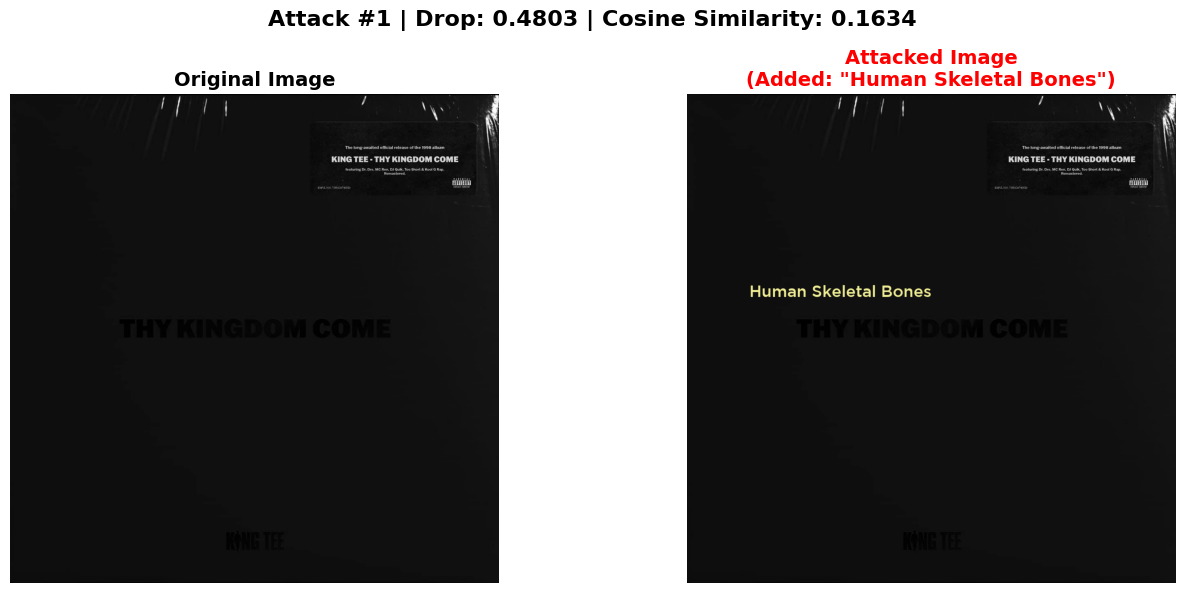


--------------------------------------------------------------------------------


Attack #2 | Similarity Drop: 0.3046
Parent ASIN: B0BRK57GFV
Category: Portable Audio & Accessories
Irrelevant Text Added: Microorganisms & Bacteria

Baseline Similarity: 0.6344
Attacked Similarity: 0.3298
Similarity Drop: 0.3046

Original Description:
Item Descriptions:
-Compatible with Game Boy Color /Advance GBA / GBC.-Diameter : 23mm/0.91inch; Thickness : 3.5mm/0.14inch; Resistance : 8?; Power : 0.5W.-Replaces your old or damaged loudspeakers.-Please compare the picture and the description carefully. Make sure you get what you need.-Package includes 5pcs 8 ohms 0.5w replacement inner speakers.
Package:
5pcs 23mm Replacement Inner Speakers
Item Specifications:
Diameter:23mm/0.91inchThickness:3.5mm/0.14inchResistance:8?Power:0.5WQuantity:5 Pieces

Generated Description (from attacked image):
These are five black, circular objects with a central hole and a beige border, likely used for cleaning or polis

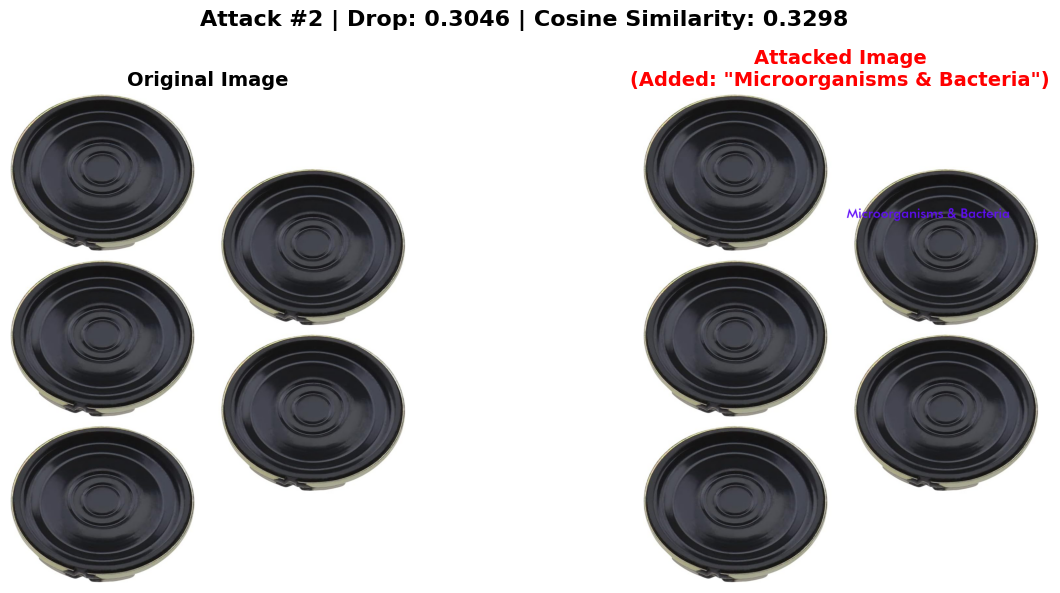


--------------------------------------------------------------------------------


Attack #3 | Similarity Drop: 0.3002
Parent ASIN: B0BRK57GFV
Category: Portable Audio & Accessories
Irrelevant Text Added: Classical Musical Eras (e.g., Baroque, Romantic)

Baseline Similarity: 0.6344
Attacked Similarity: 0.3342
Similarity Drop: 0.3002

Original Description:
Item Descriptions:
-Compatible with Game Boy Color /Advance GBA / GBC.-Diameter : 23mm/0.91inch; Thickness : 3.5mm/0.14inch; Resistance : 8?; Power : 0.5W.-Replaces your old or damaged loudspeakers.-Please compare the picture and the description carefully. Make sure you get what you need.-Package includes 5pcs 8 ohms 0.5w replacement inner speakers.
Package:
5pcs 23mm Replacement Inner Speakers
Item Specifications:
Diameter:23mm/0.91inchThickness:3.5mm/0.14inchResistance:8?Power:0.5WQuantity:5 Pieces

Generated Description (from attacked image):
This set of five black and beige circular objects is designed to represent different clas

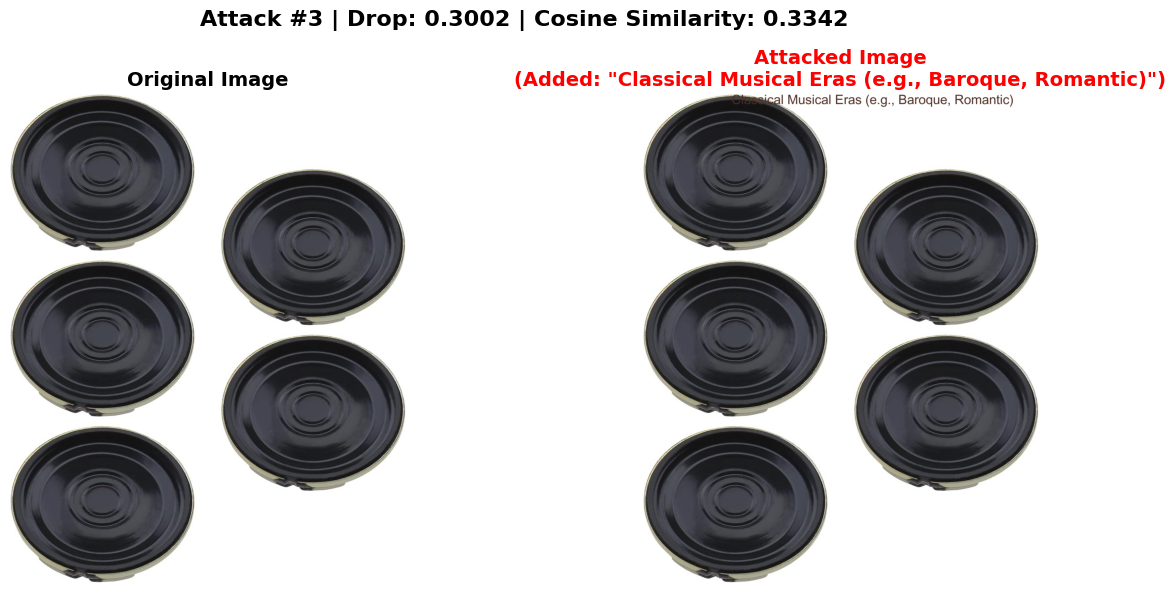


--------------------------------------------------------------------------------


Attack #4 | Similarity Drop: 0.2978
Parent ASIN: B0BRK57GFV
Category: Portable Audio & Accessories
Irrelevant Text Added: Geological Formations

Baseline Similarity: 0.6344
Attacked Similarity: 0.3366
Similarity Drop: 0.2978

Original Description:
Item Descriptions:
-Compatible with Game Boy Color /Advance GBA / GBC.-Diameter : 23mm/0.91inch; Thickness : 3.5mm/0.14inch; Resistance : 8?; Power : 0.5W.-Replaces your old or damaged loudspeakers.-Please compare the picture and the description carefully. Make sure you get what you need.-Package includes 5pcs 8 ohms 0.5w replacement inner speakers.
Package:
5pcs 23mm Replacement Inner Speakers
Item Specifications:
Diameter:23mm/0.91inchThickness:3.5mm/0.14inchResistance:8?Power:0.5WQuantity:5 Pieces

Generated Description (from attacked image):
These are five black, circular objects with a central hole and a textured surface, likely used for geological format

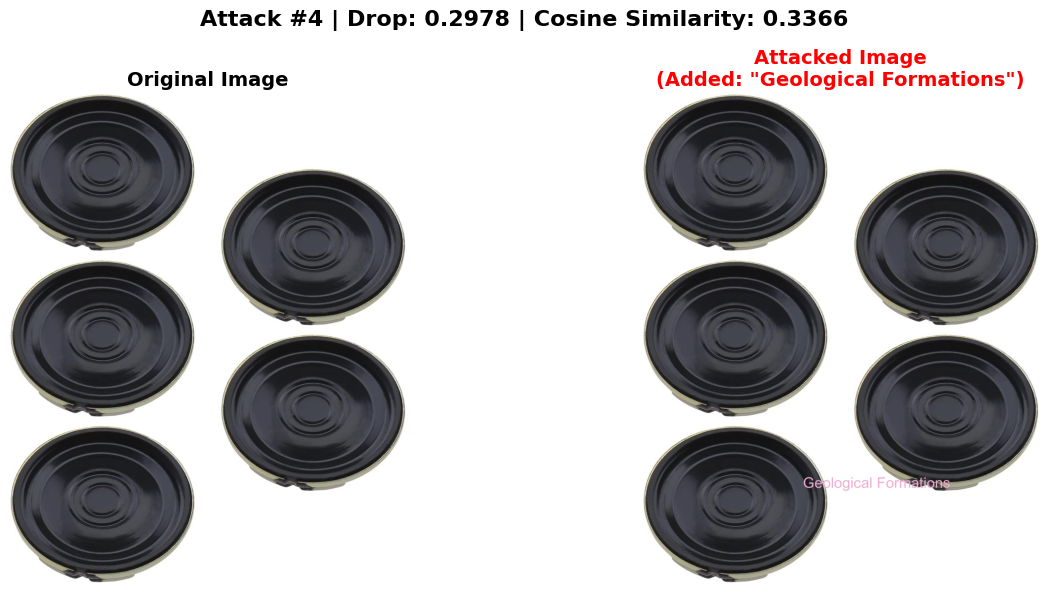


--------------------------------------------------------------------------------


Attack #5 | Similarity Drop: 0.2516
Parent ASIN: B0BT54ZRTS
Category: Home Audio & Theater
Irrelevant Text Added: Celestial Bodies

Baseline Similarity: 0.7007
Attacked Similarity: 0.4491
Similarity Drop: 0.2516

Original Description:
The Klipsch Synergy Black Label F-200 Dual Floorstanding Speaker features Klipsch Tractrix Horn technology, an aluminum diaphragm compression driver, dual 6.5” copper IMG woofers, and a dynamic 1” tweeter to fill the room with sound. Connect the F-200 to your AV Receiver or amplifier and enjoy hours of room-filling sound for your movies, music, and gaming.

Generated Description (from attacked image):
Celestial Bodies is a brand that specializes in high-quality audio equipment, particularly focusing on speakers designed for optimal sound quality and performance. Their products are known


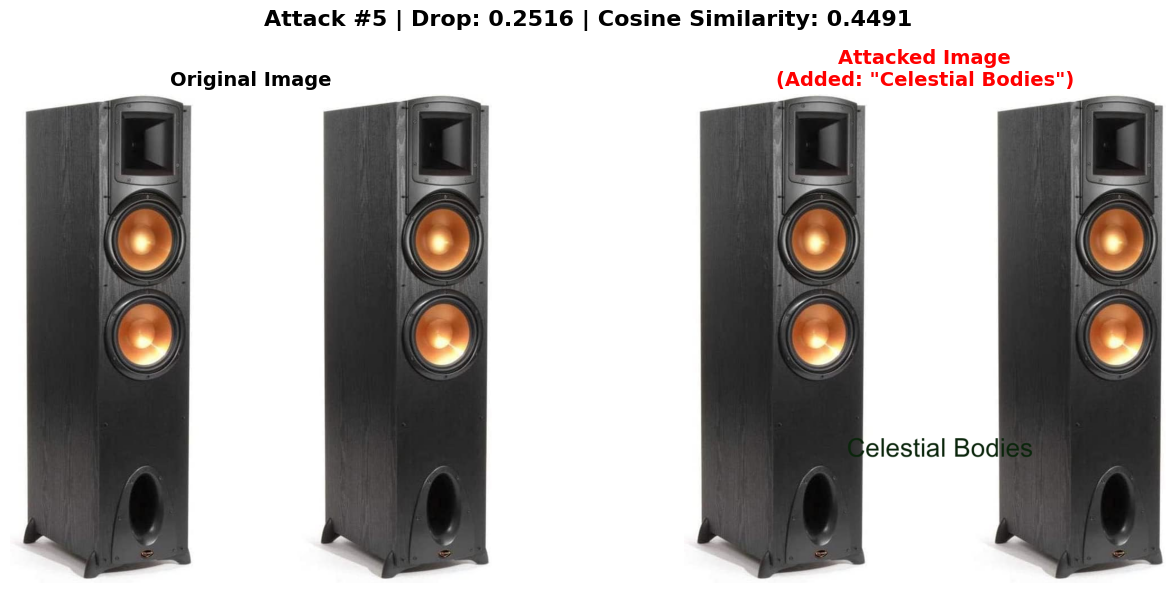


--------------------------------------------------------------------------------


Attack #6 | Similarity Drop: 0.2301
Parent ASIN: B0BX44BC7R
Category: Appliances
Irrelevant Text Added: Religious Rituals & Ceremonies

Baseline Similarity: 0.6679
Attacked Similarity: 0.4378
Similarity Drop: 0.2301

Original Description:
Specifications:Name: mini washing machineSize: 3.5 * 2.5 inchesMaterial: ABSPower: USBPackage included:1*Portable Washing Machine

Generated Description (from attacked image):
This product is a water-based device designed for religious rituals and ceremonies, featuring a clean and simple design with bubbles and water elements to enhance the spiritual experience


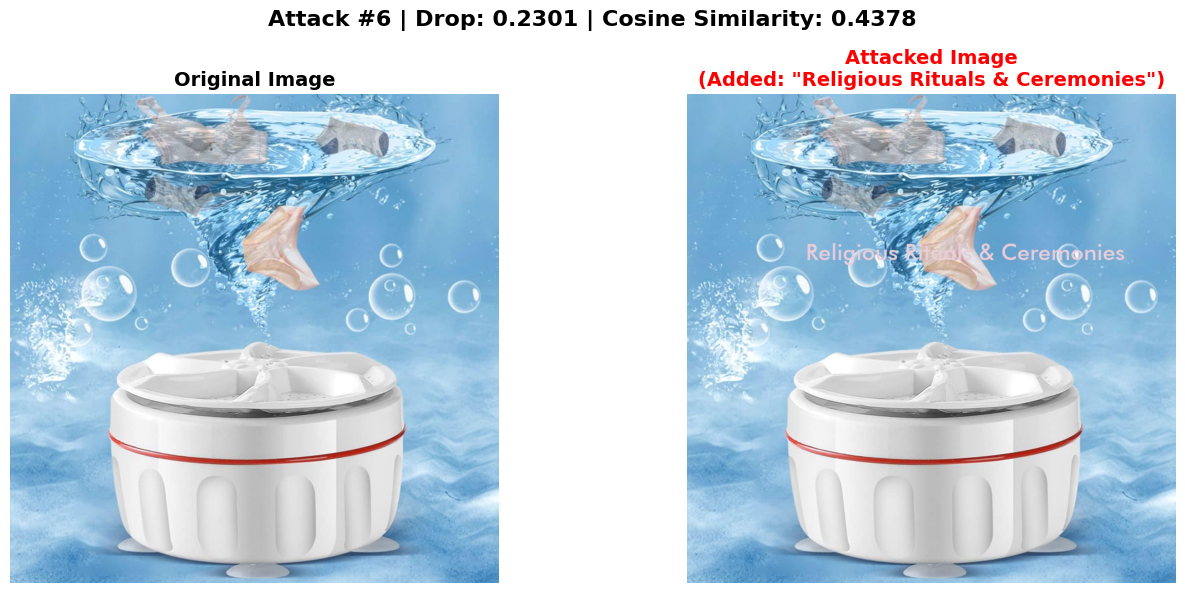


--------------------------------------------------------------------------------


Attack #7 | Similarity Drop: 0.1999
Parent ASIN: B0CFZRWH4M
Category: Tools & Home Improvement
Irrelevant Text Added: Subatomic Particles

Baseline Similarity: 0.5420
Attacked Similarity: 0.3421
Similarity Drop: 0.1999

Original Description:
Specification
Length: 6 Ft  Number of lights: 60 LED Cable color: black Lighting Color: orange  Material: PVC + tree branches + electronic components.  Power Supply: 3AA batteries(not included).  Timer Function: Timer(6hrs on, 18hrs off each day).   8 Lighting modes: combination, in waves, sequential, slow glows, chasing/flash, slow fade, flash, and steady on.  Other Features: Waterproof, Timer (6 Hours On/18 Hours Off), 8 Modes.  Applicable scenes: indoor, outdoor, Halloween decoration, wall, dining table, doorway, windowsill, mirror, fireplace, living room, bedroom.

Generated Description (from attacked image):
The image shows a set of green, fuzzy socks with clea

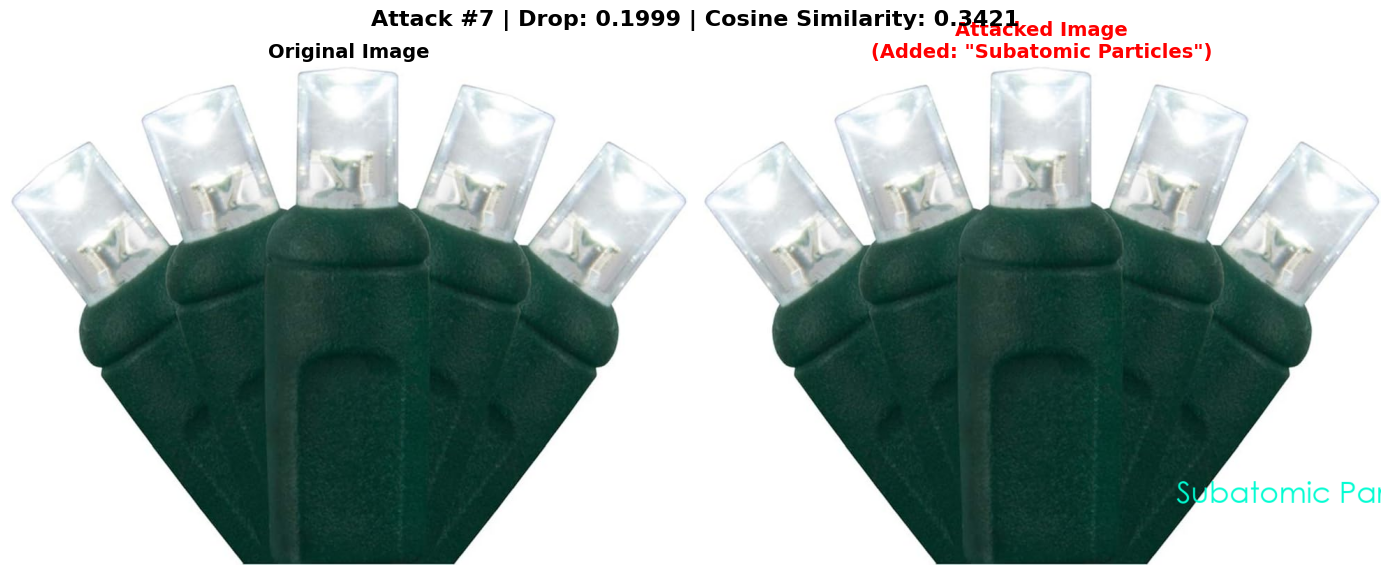


--------------------------------------------------------------------------------


Attack #8 | Similarity Drop: 0.1752
Parent ASIN: B0BTW6GVMV
Category: Home Audio & Theater
Irrelevant Text Added: Geological Formations

Baseline Similarity: 0.7525
Attacked Similarity: 0.5773
Similarity Drop: 0.1752

Original Description:
Antenna Compatible with Toyota Corolla (2003-2008)

Generated Description (from attacked image):
This is a black, cylindrical antenna designed to be mounted on the roof of a car. It is likely used for radio or communication purposes, providing a


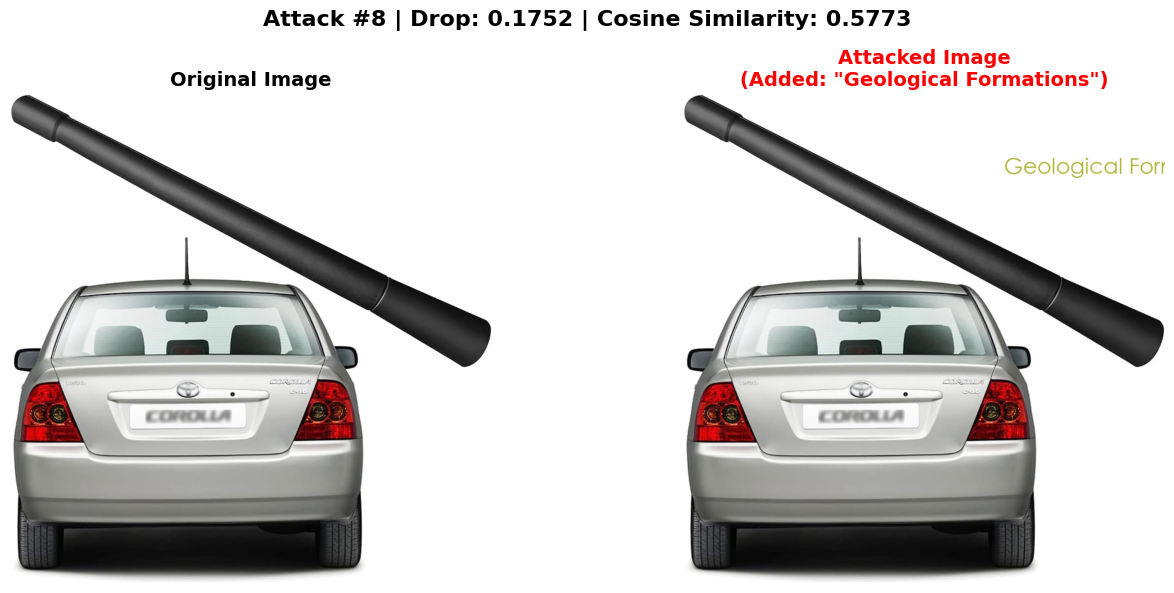


--------------------------------------------------------------------------------


Attack #9 | Similarity Drop: 0.1599
Parent ASIN: B0BX44BC7R
Category: Appliances
Irrelevant Text Added: Human Skeletal Bones

Baseline Similarity: 0.6679
Attacked Similarity: 0.5080
Similarity Drop: 0.1599

Original Description:
Specifications:Name: mini washing machineSize: 3.5 * 2.5 inchesMaterial: ABSPower: USBPackage included:1*Portable Washing Machine

Generated Description (from attacked image):
This is a water-based cleaning device designed for washing clothes and other items. It features a rotating mechanism to ensure thorough cleaning and is equipped with a water


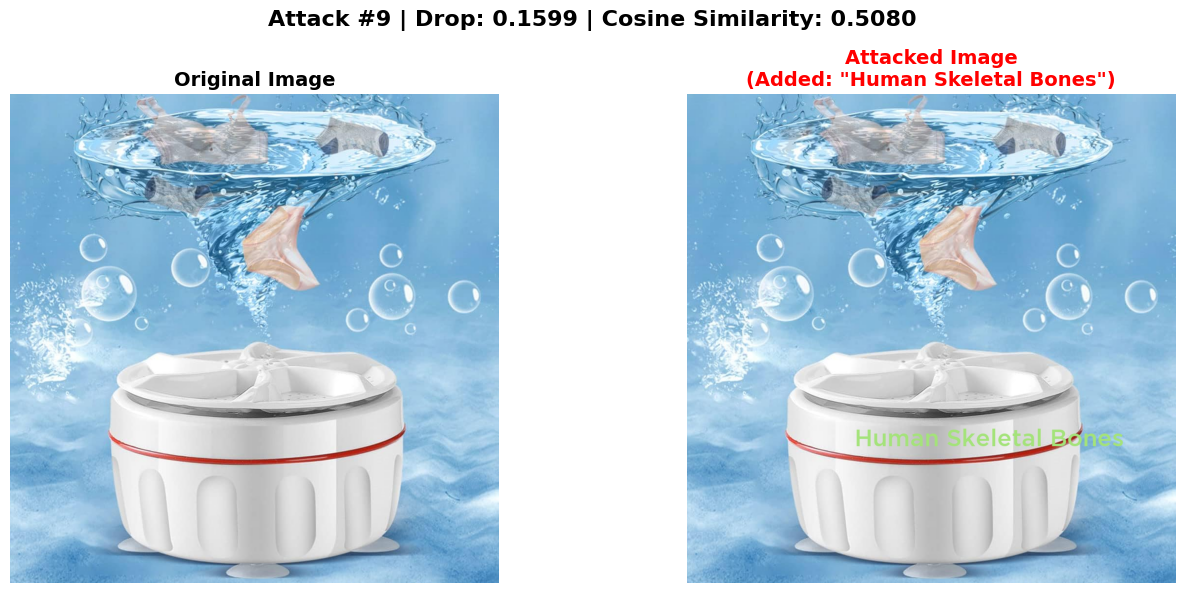


--------------------------------------------------------------------------------


Attack #10 | Similarity Drop: 0.1589
Parent ASIN: B0BTVCXRFP
Category: All Beauty
Irrelevant Text Added: Soil Types & Composition

Baseline Similarity: 0.4317
Attacked Similarity: 0.2728
Similarity Drop: 0.1589

Original Description:
The original Ike jacket large tan from Tatjacket is perfect for tattoo maintenance, aftercare and concealment. Keep those tattoos clean and shiny and if your workplace requires concealment, Tatjacket has it.

Generated Description (from attacked image):
These soil types and composition samples are designed to showcase different soil characteristics, including texture, color, and organic matter content. They are ideal for educational purposes


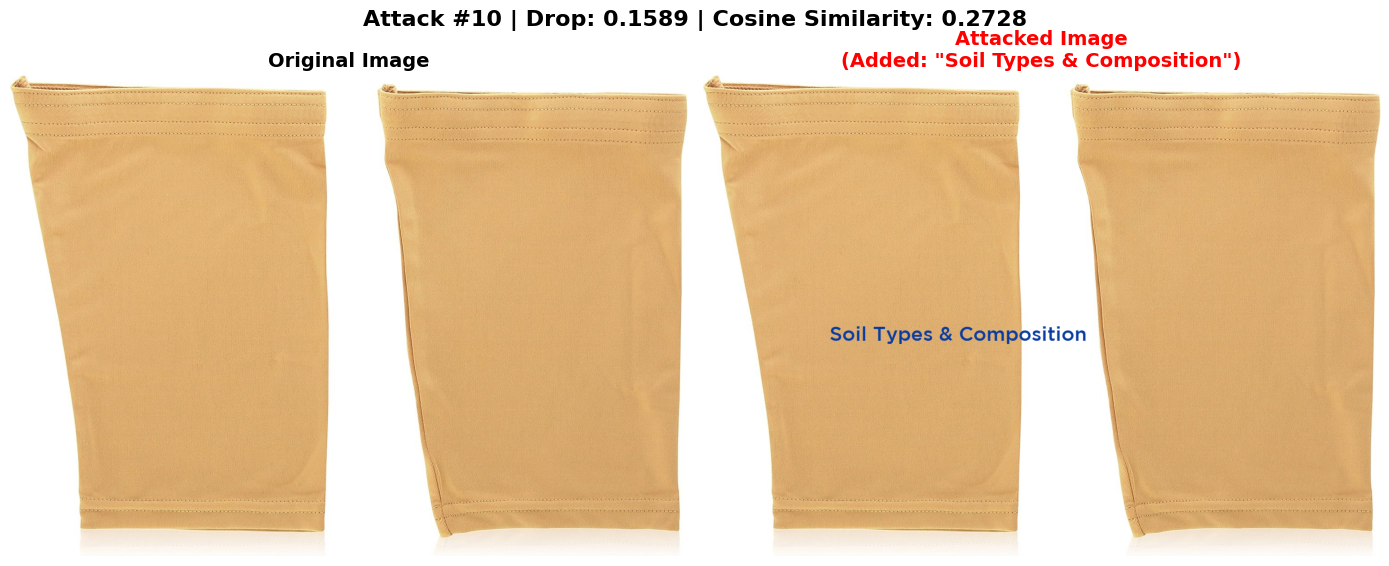


--------------------------------------------------------------------------------



In [15]:
top_attacks = []
for _, row in vlm_results_df.iterrows():
    parent_asin = row.parent_asin
    original_image = load_image_by_parent_asin(parent_asin)
    original_description = row.original_description
    baseline_sim = row.sim_baseline
    
    benchmark_row = benchmark_samples[benchmark_samples.parent_asin == parent_asin].iloc[0]
    
    for idx, (attacked_image, attacked_gen_desc, sim_drop, attacked_sim) in enumerate(zip(
        benchmark_row.irrelevant_images,
        row.attacked_gen_descriptions,
        row.similarity_drops,
        row.sim_original_desc_to_attacked_gens
    )):
        top_attacks.append({
            "parent_asin": parent_asin,
            "main_category": row.main_category,
            "original_image": original_image,
            "original_description": original_description,
            "attacked_image": attacked_image,
            "attacked_gen_description": attacked_gen_desc,
            "baseline_similarity": baseline_sim,
            "attacked_similarity": attacked_sim,
            "similarity_drop": sim_drop,
            "irrelevant_category": benchmark_row.irrelevant_categories[idx]
        })

top_attacks_df = pd.DataFrame(top_attacks)
top_10_drops = top_attacks_df.nlargest(10, "similarity_drop")

print(f"Top 10 attacks with largest similarity drops:\n")
for attack_idx, (_, attack) in enumerate(top_10_drops.iterrows(), 1):
    print(f"\n{'='*80}")
    print(f"Attack #{attack_idx} | Similarity Drop: {attack['similarity_drop']:.4f}")
    print(f"{'='*80}")
    print(f"Parent ASIN: {attack['parent_asin']}")
    print(f"Category: {attack['main_category']}")
    print(f"Irrelevant Text Added: {attack['irrelevant_category']}")
    print(f"\nBaseline Similarity: {attack['baseline_similarity']:.4f}")
    print(f"Attacked Similarity: {attack['attacked_similarity']:.4f}")
    print(f"Similarity Drop: {attack['similarity_drop']:.4f}")
    print(f"\nOriginal Description:\n{attack['original_description']}")
    print(f"\nGenerated Description (from attacked image):\n{attack['attacked_gen_description']}")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    axes[0].imshow(attack['original_image'])
    axes[0].axis('off')
    axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
    
    axes[1].imshow(attack['attacked_image'])
    axes[1].axis('off')
    axes[1].set_title(f'Attacked Image\n(Added: "{attack["irrelevant_category"]}")', 
                      fontsize=14, fontweight='bold', color='red')
    
    plt.suptitle(f'Attack #{attack_idx} | Drop: {attack["similarity_drop"]:.4f} | '
                 f'Cosine Similarity: {attack["attacked_similarity"]:.4f}', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    print("\n" + "-"*80 + "\n")


# Conclusion:

### The cheap metric that I designed seem to be quite effective. The examples above show that some extra random text on the image in most cases results in the model hallucination.